# Report for 2D Project Physical World and Digital World

Cohort: #5

Team No.: #8

Members:
* Lionell Loh (1003145)
* Celine Yee (1003074)
* Claire Tan (1002839)
* Zhao Wen Qiang (1002955)
* Cheow Yi Jian (1002940)


# Introduction

Temperature sensors need to reach quasi-thermal equilibrium with the environment in order to measure its temperature accurately. The time taken to reach thermal equilibrium however can be a long wait. For instance, the sensor originally at room temperature takes more than 70 seconds before it is able to reflect the temperature of a water bath at 60 deg celsius. This 70 seconds was the time taken for the sensor to reach quasi-thermal equilibrium with the water bath. 

In order to expedite this process, we augment the hardware with predictive programmes. More specfically, we build a predictive model with training data with Machine Learning algorithms. Using this predictive model, we are able to take raw sensor data from the first 10 seconds to give an accurate temperature of the water bath, with an average standard deviation of 1%.  

Write your introduction here. Describe the problem you want to solve and a brief of your approach and summary of your result.


# Description of Data from Experiment

## Data Collection

### Concerns about Time and Space
The collection of data was done with the temperature sensor attached to a Raspberry Pi in the classroom.
The location for data collection is not trivial as each location has unique environment variables that must be kept as consistent as possible at the point of prediction. 

For example, the ambient temperature of the classroom is 0.7 degree cooler than the temperature beside the pantry. Even within the classroom, the temperature at night is 0.4 degree warmer than the temperature in the day, as the air conditioners are switched off at night. 

Since the conditions for data collection can be controlled, our group decided to make special arrangements to collect our data in the day, in the classroom, to keep external variables as consistent as possible. While deviation of such variables might be small, if they are not kept constant, we might still have to factor them in as "features" to train our model, which complicates the process.

### Collection Method 
We printed the temperature on the Python3 Shell and saved the Shell outputs as a text file for processing thereafter. We opted for this method as we realised that writing the values to a csv file somehow slowed down the temperature reading interval by 0.08 seconds. This could be due to the additional processing overhead when writing data to files that is especially significant considering the limited RAM of the RPi3. 






## Data Preparation

When preparing the data, we want to make sure that there is no "noise" in the data due to imperfect execution. To be sure, we decided to visualise the data. 

The code below processes the text file, creates two lists of data - one for time interval and the other for temperatures. We then plot the temperature data against the time intervals.

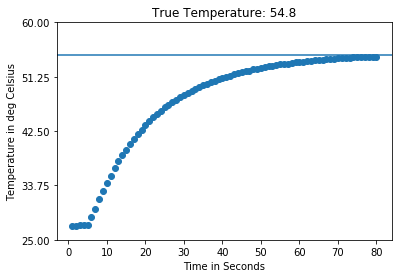

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def processfile(file_object):
    time_s = list(np.linspace(1,80, 80))
    temp = []
    for line in file_object:
        try:
            t = line.split(",")
            T_float = float(t[0][1:])
            temp.append(T_float)
        except: 
            
            t = line.split(" ")
            T_float = float(t[0])
            temp.append(T_float)
            
    return time_s, temp
        
f = open("./Data_54.8.txt", "r")
time_s, temp = processfile(f)

plt.title("True Temperature: 54.8")
plt.xlabel("Time in Seconds")
plt.ylabel("Temperature in deg Celsius")
plt.scatter(time_s, temp[:80])
plt.xticks()
plt.yticks(list(np.linspace(25,60, 5)))
plt.axhline(54.8)
plt.show()

With the visualisation plot above, we can see that there was a significant delay in inserting the temperature sensor. Taking the the first few data points would thus misguide our model. We then went to manually erase the data that was a result of bad execution. 

Another insight we gained was that during prediction, there might be similar instances of lag time. This insight made systematically exclude the first few seconds of data collecte by the sensor during prediction. 

## Data Format

We realised how the temperature of the sensor changes with time might be a function of the actual temperature of the water bath. This corresponds with our Physical World knowledge that rate of thermal conduction is a function of the temperature difference. The greater the difference between the water bath temperature and the sensor, the faster the sensor gains heat and the faster the readings increase.

We thus wanted to test if the gradient of the temperate-time graph has a correlation with the true temperature of the water bath. Our hypothesis was that the higher the value of the gradient (the steeper the gradient) the higher the actual temperature of the water bath.

### Finding Gradient 
To find the gradient of the temperature-time graph, we used linear regression on the temperature time graph take the gradient of the line to be the gradient of the temperature-time graph. In this context, the gradient, refers to the average rate of change of temperature. 

To find the best-fit line, we use the curve_fit function from scipy.optimize.

The gradient for 54.8 deg for the first 25 points is 0.8487415384612085


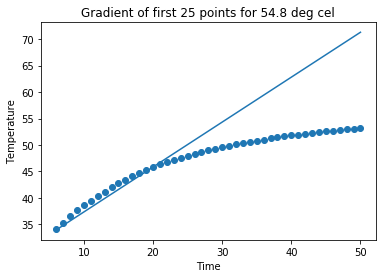

In [21]:
from scipy.optimize import curve_fit

def func(x, m, c):
        return m*x + c


f = open("54.8.txt", "r")
time_s, temp = processfile(f)

def find_gradient(temp, points):
    
    time_s = np.linspace(1,30, 30)
    params, extras = curve_fit(func, time_s[:points], temp[:points])
    return params[0], params[1]

gradient, intercept = find_gradient(temp, 25)
print("The gradient for 54.8 deg for the first 25 points is {}".format(gradient))

plt.scatter(time_s[5:50], temp[5:50])
plt.plot(time_s[5:50], [func(t, gradient, intercept) for t in time_s[5:50]])
plt.title("Gradient of first 25 points for 54.8 deg cel")
plt.xlabel("Time")
plt.ylabel("Temperature")

plt.show()



The code above finds the gradient for the first 25 points of data for one temperature of water bath. This is the maximum number of data we may collect, as our temperature sensor collects data at 1 second interval and our aim is to achieve prediction in 25 seconds or less.

We then find the gradient for all our training data sets with the code below. 

In [22]:
import glob
files = glob.glob("TrainingData/*")

real_temps = []
gradients = []

for file in sorted(files):
    
    real_temp = float(file[13:17])
    f = open(file, 'r')
    temps = processfile(f)[1]
    gradient, intercept = find_gradient(temps, 24)
    real_temps.append(real_temp)
    gradients.append(gradient)
    print("The gradient for temperature: {} is {}".format(real_temp, gradient))
    

The gradient for temperature: 10.7 is -0.4610513044374103
The gradient for temperature: 14.8 is -0.36091304348122955
The gradient for temperature: 16.8 is -0.34565130435076097
The gradient for temperature: 21.1 is -0.15906913043730952
The gradient for temperature: 24.7 is -0.05997217391535492
The gradient for temperature: 30.4 is 0.08170434835380307
The gradient for temperature: 32.3 is 0.14886304347640467
The gradient for temperature: 33.5 is 0.17561739130254939
The gradient for temperature: 35.0 is 0.1803556523444608
The gradient for temperature: 36.3 is 0.21905391330430204
The gradient for temperature: 40.1 is 0.3714660875429607
The gradient for temperature: 41.6 is 0.3932908695638946
The gradient for temperature: 41.8 is 0.4826647825863217
The gradient for temperature: 44.3 is 0.5121499998131008
The gradient for temperature: 47.3 is 0.5196465217380833
The gradient for temperature: 48.3 is 0.5731595652164603
The gradient for temperature: 50.6 is 0.6731778260862424
The gradient for t

### Determining the strength of Linear Correlation
Now that we have collated the gradients for different temperatures of the water bath, we visualised it by plotting a graph of "Temperature of Water Bath" against "Gradient". 

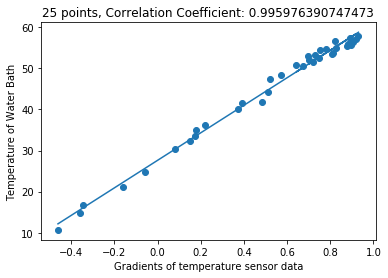

In [23]:
from scipy.stats import pearsonr

correlation = pearsonr(gradients, real_temps)

params, extras = curve_fit(func, gradients, real_temps)

plt.scatter(gradients, real_temps)
plt.plot(gradients, [func(gradient, *params) for gradient in gradients])
plt.xlabel("Gradients of temperature sensor data")
plt.ylabel("Temperature of Water Bath")
plt.title("{} points, Correlation Coefficient: {}".format(25, correlation[0]))

plt.show()



### Insights from results


Visually, we can see that the there is a strong linear coefficient. Numerically the Correlation coefficient is 0.9959, which is very close to 1. This suggests a strong linear correlation between Temperature of Water Bath and the Gradients of the temperature sensor data. With this as validation of our hypothesis, we decide to build a linear regression model based on this.

However, how many points of data should we use to derive our gradient value? In order to ascertain the number of data points is the best, we decided to use a rigorous and comprehensive method to collate 5 different gradients for each temperature, and compare their coorelation coefficient.

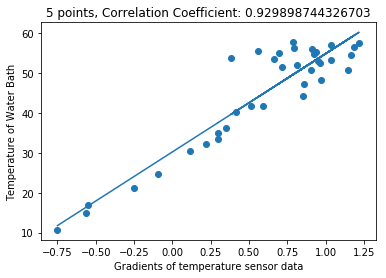

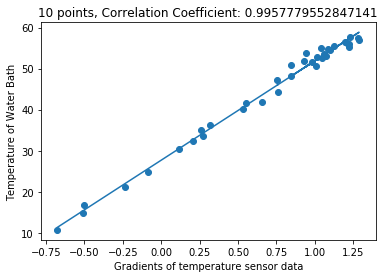

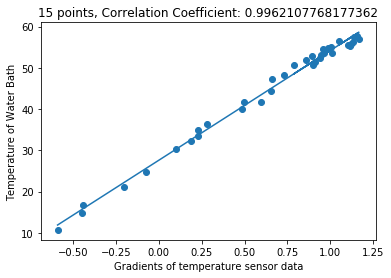

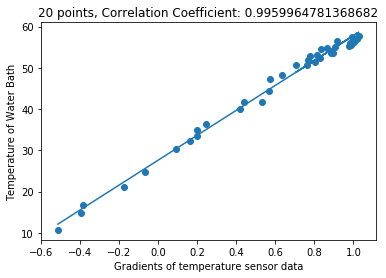

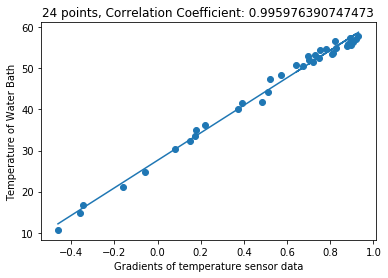

In [24]:
correlations = []

for i in range(5, 30):
    
    gradients = []
    real_temps = []
    for file in sorted(files):
#         print(file)
        real_temp = float(file[13:17])
        f = open(file, 'r')
        temps = processfile(f)[1]
        gradient, intercept = find_gradient(temps, i)
        real_temps.append(real_temp)
        gradients.append(gradient)
    
    correlation = pearsonr(gradients, real_temps)
    correlations.append(correlation[0])

    params, extras = curve_fit(func, gradients, real_temps)

    
    
    if i in [5,10,15,20, 24]:
        plt.scatter(gradients, real_temps)
        plt.plot(gradients, [func(gradient, *params) for gradient in gradients])
        plt.xlabel("Gradients of temperature sensor data")
        plt.ylabel("Temperature of Water Bath")
        plt.title("{} points, Correlation Coefficient: {}".format(i, correlation[0]))
        plt.show()



    
    

Visually, based on comparison, we can see that the best fit line is better done when the gradients are derived from more points, than less.

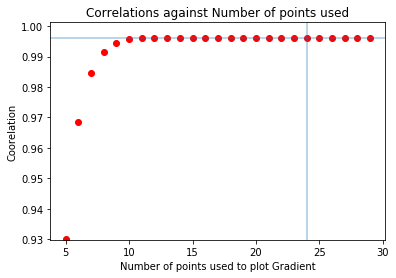

In [25]:
num_of_points = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]
plt.scatter(num_of_points, correlations, color = "red")
plt.xlabel("Number of points used to plot Gradient")
plt.ylabel("Coorelation")
plt.ylim(min(correlations) - 0.0001, max(correlations) + 0.005)
plt.axhline(correlations[19], alpha = 0.4)
plt.axvline(24, alpha = 0.4)
plt.title("Correlations against Number of points used")
plt.show()

### Choosing how many points to derive gradient from 

Based on the graph above, we can see that the coorelation increases  when more points are considered for the gradient. We decided to use 24 points to generate our gradient as it gives us a strong linear correlation with the water bath's temperature, and at the same time, using 24 data points (~24 seconds) give us sufficient buffer before we cross the 25 seconds requirement during the actual prediction.

# Training Model

Using the gradients derived from 24 data points, we trained a linear model of Temperatures against Gradients. The model is saved using Pickle and loaded thereafter for inference and prediction. 

In [26]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = [[gradient] for gradient in gradients]
y = [[real_temp] for real_temp in real_temps]
regr.fit(np.array(x), np.array(y))

import pickle

pickle.dump(regr, open("linear_model", 'wb'))
clf = pickle.load(open("linear_model", 'rb'))

/Users/new/.virtualenvs/facecourse-py3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


# Verification and Accuracy

Having trained the model, I reserved 5 out of 40 data sets to do validation of accuracy. These 5 sets of data were not included in the training of the model to prevent bias results.

In [27]:
import glob
# import math
files = glob.glob("TestingData/*")
grads_test = []
real_temps_test = []
for file in files: 
    temps_ = []
    real_temp = float(file[17:21])
    real_temps_test.append(real_temp)
    f = open(file, 'r')
    
    for line in f: 
        t = float((line.split(' ')[0]))
        temps_.append(t)

    grad, intercept = find_gradient(temps_,20)
    grads_test.append(grad)

sorted_prediction_results_list = [e[0] for e in sorted(clf.predict([[grad] for grad in grads_test]))]
print("Temperature files being predicted:", sorted(real_temps_test))
print("Prediction results:", sorted_prediction_results_list)


    
    


Temperature files being predicted: [25.2, 31.4, 35.3, 36.6, 41.1]
Prediction results: [24.926637509995565, 31.026330661446391, 35.165368532903059, 36.829366125197168, 41.303559476889042]


We then calculate the average percentage of error for the 5 test cases.
We do so by taking the absolute difference between the predicted temperature and the actual temperature as a percentage of the actual temperature. 

In [28]:
percentage_errors = []
for i in range(len(real_temps_test)): 
    error = abs(sorted(real_temps_test)[i]-sorted_prediction_results_list[i])/sorted(real_temps_test)[i]*100

    percentage_errors.append(error)
    
print("Average Error Percentage = {}%".format(sum(percentage_errors)/len(percentage_errors)))

Average Error Percentage = 0.7556311438336477%


# Testing Using Instructor's Data

Instruction:

* Store your trained model into a pickle object which can be loaded. 
* Read an excel file with the following format:
```
time (s)	reading
0.00	    25.812
0.90	    28.562
1.79	    31.875
2.68	    35.062
3.55	    37.937
4.43	    40.687
5.30	    43.25
```
where the first column indicates the time in seconds and the second column indicates the sensor reading in Celsius. 
* The number of rows in the instructors' data can be of any number. If your code has a minimum number of rows, your code must be able to handle and exit safely when the data provided is less than the required minimum.
* Write a code to prepare the data for prediction.
* Write a code to predict the final temperature.



In [29]:
# write a code to load your trained model from a pickle object
import pickle
filename = '' # enter your pickle file name containing the model
with open("linear_model",'rb') as f:
    model = pickle.load(f)


In [30]:
# write a code to read an excel file
import pandas as pd
num_test = 1
filename = 'temp_' 
filekey = ['51'] # instructors will key in this
dataframe = {} # this is to store the data for different temperature, the keys are in filekey
for idx in range(num_test):
    dataframe[filekey[idx]] = pd.read_excel(filename+filekey[idx]+'.xlsx')


In [31]:
# write a code to prepare the data for predicting
def preprocess(df):
    # process the data to get the gradient of the best fit line 
    timelst = []
    templst = []
    for time_index in range(len(df['time (s)'])):
        if df['time (s)'][time_index] < 25:
            timelst.append(df['time (s)'][time_index])
            templst.append(df['reading'][time_index])
#     print(timelst)
#     print(templst)
    
    
    return find_gradient(templst[2:], len(timelst)-2)[0]

data_test = {}
for key in filekey:
    
    print("Gradient for temp_51.xlsx is {}". format(preprocess(dataframe[key])))
    data_test[key]=preprocess(dataframe[key])

Gradient for temp_51.xlsx is 0.5786428571691727


In [32]:
# write a code to predict the final temperature
# store the predicted temperature in a variable called "predicted"
# predicted is a dictionary where the keys are listed in filekey

predicted = {}
for key in filekey:
    print(key)
    predicted[key]=model.predict(data_test[key])
print(predicted)

51
{'51': array([[ 49.49396954]])}


In [188]:
# checking accuracy

# first instructor will load the actual temp from a pickle object
import pickle
error_d = {}
accuracy_percent_d = {}

for test in range(num_test):
    filename = 'data_'+filekey[test]+'.pickle'
    with open("linear_model",'rb') as f:
        final_temp, worst_temp = pickle.load(f)

    # then calculate the error
    error_final = abs(final_temp-predicted[filekey[test]])
    accuracy_final_percent = 100-error_final/final_temp*100
    error_worst = abs(worst_temp-predicted[filekey[test]])
    accuracy_worst_percent = 100-error_worst/worst_temp*100
    
    error_d[filekey[test]] = (error_final, error_worst)
    accuracy_percent_d[filekey[test]] = (accuracy_final_percent, accuracy_worst_percent)

    # displaying the error
    print('===================================')
    print('Testing: {}'.format(filekey[test]))
    print('Predicted Temp: {:.2f}'.format(predicted[filekey[test]]))
    print('Final Sensor Temp: {:.2f}, Alcohol Temp:{:.2f}'.format(final_temp, worst_temp))
    print('Error w.r.t Final Sensor Temp: {:.2f} deg, {:.2f}% accuracy'.format(error_final, accuracy_final_percent))
    print('Error w.r.t Alcohol Temp: {:.2f} deg, {:.2f}% accuracy'.format(error_worst, accuracy_worst_percent))
    
avg_final = sum([ final for final, worst in accuracy_percent_d.values()])/len(error_d.values())
avg_worst = sum([ worst for final, worst in accuracy_percent_d.values()])/len(error_d.values())
print('==============================')
print('Average accuracy for final sensor temp: {:.2f}'.format(avg_final))
print('AVerage accuracy for alcohol temp: {:.2f}'.format(avg_worst))


TypeError: 'LinearRegression' object is not iterable

# An alternative method

Using our knowledge from physical world, we know that there is a strong logarithmic fit to the sensor data. When predicting, I experimented with __building a model on a fly__ and created a logarithmic model using the first 20 data points. The result is extremely accurate. (if accuracy was defined as <1.5 deg deviation) 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[27.312, 28.625, 30.0, 31.5, 32.812, 34.125, 35.312, 36.5, 37.625, 38.625, 39.5, 40.437, 41.187, 42.0, 42.75, 43.437, 44.125, 44.687, 45.25, 45.75, 46.312, 46.75, 47.187, 47.562, 47.937, 48.312, 48.687, 49.0, 49.312, 49.625]
params is [  7.34318389  14.46779569   3.17437324]
Left limit: 63.7, Right Limit : 95.85


/Users/new/.virtualenvs/facecourse-py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log


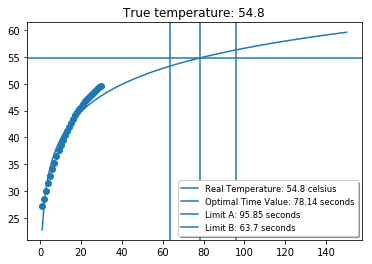

In [34]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

f = open("54.8.txt")
real_temp = 54.8

count = 0
x1 = []
x2 = []
for line in f:
	if count < 30:
		count+=1
		x1.append(count)
		t = line.split(",")
		T_float = float(t[0][1:])
		x2.append(T_float)
		# y.append(22.7)

	else:
		break
        
print(x1)
print(x2)
        
def func(x, a, b, c):
	return a * np.log(b*x) + c

def reverse(y, a, b, c):
	return np.exp((y - c)/a)/b

params, extras = curve_fit(func, x1[:24], x2[:24])

np.polyfit(np.log(np.array(x1[:25])), np.array(x2[:25]), 1)
print("params is", params)
plt.scatter(x1, x2)
x1 = np.linspace(1, 150, 150)
# plt.plot(x1, [func(x, params[0], params[1], params[2], params[3], params[4]) for x in x1])
# plt.plot(x1, [func(x, *params) for x in x1])
plt.plot(x1, [func(x,*params) for x in x1])
plt.axhline(real_temp, label = "Real Temperature: {} celsius". format(real_temp))
plt.axvline(reverse(real_temp, *params), label = "Optimal Time Value: {} seconds".format(round(reverse(real_temp, *params),2)))
plt.axvline(reverse(real_temp+1.5, *params), label = "Limit A: {} seconds".format(round(reverse(real_temp+1.5, *params),2)))
plt.axvline(reverse(real_temp-1.5, *params), label = "Limit B: {} seconds".format(round(reverse(real_temp-1.5, *params),2)))
plt.title("True temperature: {}".format(real_temp))

legend = plt.legend(loc='best', shadow=True, fontsize='small')
print("Left limit: {}, Right Limit : {}".format(round(reverse(real_temp-1.5, *params),2), round(reverse(real_temp+1.5, *params),2)))

plt.show()

As can be seen below, the log curve is plotted for the first 24 points using an optimizing function, __curve_fit__. Thereafter, a logarithmic model allows for a large margin of error to fulfil an accuracy of <1.5 degree deviation. As can be seen, once the model is built, it can be anythin between 63.7 and 95.85 seconds can be fed in to the equation to get a temperature that is within 1.5 degrees of the true temperature. 

However, the model has to be trained every time it predict and it does not really improve with more data sets. This was a "unique" form of Machine Learning that we call __training the model on a fly__. For our learning's sake, we decided to abandon this way to computing the true temperature and try to create one general linear model that may work well through interpolation. 

# Conclusion and Discussion

We first hypothesized that the gradient of the temperature sensor has a strong linear correlation with the actual temperature of the water bath. This turns out to be true. When we confirmed that, we became very confident about this approach of training a model.

However, the gradient of the sensor data against time can be quite heavily affected by the ambient temperature. Why is that so? The gradient of sensor data when ambient temperature is 25 degrees and when the water bath is 60 degrees is bound to be higher than when ambient temperature is 28 degrees. If the data was trained with 25 degrees ambient temperature, then the model will mostly likely underestimate the temperature of the water bath when the ambient temperature is 28 degrees. 

This can be seen as the weakness of our model. Even though we were able to exploit the linear relationship that the actual temperature and the gradient of the sensor data share, we set off being too fixated with precision and perfection. Our first model (not uploaded here) was trained with a highly controlled ambient temperature - 27 +- 0.2 deg. While it helped us predict our data to an extremely high accuracy. (<0.1 deg deviation) This caused our model to be not as robust, and predict inaccurately (> 2 degrees off) when ambient temperature is more than 1.5 degree off. 

We thus decided to include a greater range of ambient temperature. From 26 to 27.8 degrees to so that our model will have a greater threshold for different ambient temperatures. As we do this, we sacrifice precision for a specific ambient temperature but still maintain the ability to generalise over a meaningful range. While it was tempting to chase after the a <0.1 degrees deviation, this will render the model useless if it only serves a specific, narrow set of situations. In some sense, we felt that training the model to predict accurate for one set of ambient temperature can be seen as "overfitting". This taught me that in many cases, predictive models are still limited today. To sharpen the accuracy will bound to be met with sacrificies in other aspects. 